https://stats.stackexchange.com/questions/13166/rs-lmer-cheat-sheet

In [125]:
library(tidyverse)
library(magrittr)
library(readxl)
library(lmerTest)
library(emmeans)

In [126]:
exp1 = read_xlsx('CLICK-it_WB_cumulative_LCLs.xlsx', sheet=1)

In [127]:
head(exp1)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,AA,HG01112,Vehicle,81.42,9.044,0.002
1,AA,HG01112,Vehicle,70.22,8.711,0.002
1,AA,HG01112,Vehicle,68.05,8.363,0.002
1,AA,HG01112,Thapsi,27.08,10.176,0.002
1,AA,HG01112,Thapsi,30.90,10.219,0.002
1,AA,HG01112,Thapsi,35.83,9.784,0.002


In [128]:
exp2 = read_xlsx('CLICK-it_WB_cumulative_LCLs.xlsx', sheet=2)

In [129]:
head(exp2)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,AA,HG01932,Vehicle,109.16,8.949,0.431
1,AA,HG01932,Vehicle,109.00,9.232,0.431
1,AA,HG01932,Vehicle,108.88,8.651,0.431
1,AA,HG01932,Thapsi,45.41,8.341,0.431
1,AA,HG01932,Thapsi,47.33,8.482,0.431
1,AA,HG01932,Thapsi,52.55,7.780,0.431


In [130]:
df = rbind(exp1 %>% mutate(Experiment = "Exp1"),
           exp2 %>% mutate(Experiment = "Exp2", Gel = Gel + 3))

head(df)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background,Experiment
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,AA,HG01112,Vehicle,81.42,9.044,0.002,Exp1
1,AA,HG01112,Vehicle,70.22,8.711,0.002,Exp1
1,AA,HG01112,Vehicle,68.05,8.363,0.002,Exp1
1,AA,HG01112,Thapsi,27.08,10.176,0.002,Exp1
1,AA,HG01112,Thapsi,30.90,10.219,0.002,Exp1
1,AA,HG01112,Thapsi,35.83,9.784,0.002,Exp1


In [131]:
df %<>%
    group_by(Experiment) %>% # or Gel or nothing?!? depends on how gels were developed and quantified
    mutate(TAMRA_ = TAMRA-Background,
           BetaActin_ = BetaActin-Background,
           NormFactor = BetaActin_/max(BetaActin_),
           NormSignal = TAMRA_/NormFactor,
           Experiment = factor(Experiment, levels = c("Exp1", "Exp2")),
           Genotype = factor(Genotype, levels = c("AA", "CC", "EIF2B2")),
           Treatment = factor(Treatment, levels = c("Vehicle", "Thapsi"))) %>%
    ungroup()

In [132]:
head(df)

Gel,Genotype,Sample,Treatment,TAMRA,BetaActin,Background,Experiment,TAMRA_,BetaActin_,NormFactor,NormSignal
<dbl>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,AA,HG01112,Vehicle,81.42,9.044,0.002,Exp1,81.42,9.042,0.5050,161.21
1,AA,HG01112,Vehicle,70.22,8.711,0.002,Exp1,70.22,8.709,0.4864,144.36
1,AA,HG01112,Vehicle,68.05,8.363,0.002,Exp1,68.05,8.361,0.4670,145.72
1,AA,HG01112,Thapsi,27.08,10.176,0.002,Exp1,27.08,10.174,0.5683,47.65
1,AA,HG01112,Thapsi,30.90,10.219,0.002,Exp1,30.90,10.217,0.5707,54.15
1,AA,HG01112,Thapsi,35.83,9.784,0.002,Exp1,35.83,9.782,0.5464,65.58


In [133]:
df %>% write_csv("CLICK-it_WB_cumulative_LCLs.csv")

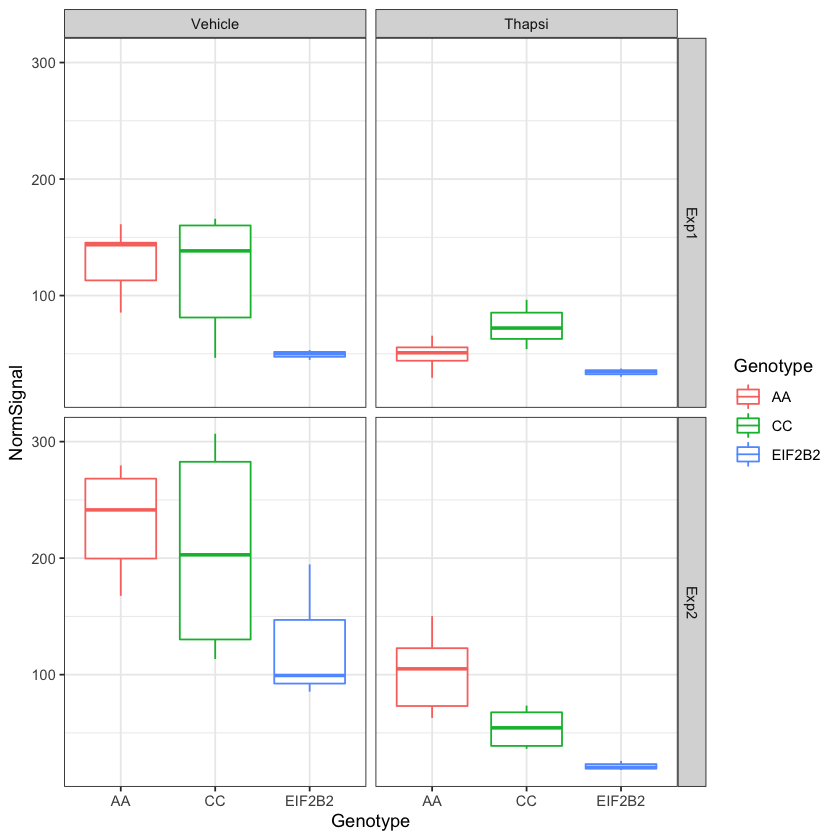

In [134]:
ggplot(df, aes(x=Genotype, y=NormSignal, col=Genotype)) + geom_boxplot() + facet_grid(rows=vars(Experiment), cols=vars(Treatment)) + theme_bw()

In [141]:
lm.full = lmer(NormSignal ~ Genotype + Treatment + (1 | Sample), data = df)

In [142]:
fixef(lm.full)

(Intercept)      GenotypeCC  GenotypeEIF2B2 TreatmentThapsi 
         175.53          -14.88          -70.70          -93.93

In [143]:
ranef(lm.full)

$`Sample:Experiment`
             (Intercept)
GM20073:Exp1       3.043
GM20074:Exp2      -3.043
HG01112:Exp1      -4.690
HG01125:Exp1     -26.681
HG01142:Exp1      11.605
HG01435:Exp1      -6.607
HG01565:Exp2      37.028
HG01572:Exp2     -42.027
HG01932:Exp2      43.641
HG02260:Exp2     -12.269

$Experiment
     (Intercept)
Exp1       -19.8
Exp2        19.8

with conditional variances for “Sample:Experiment” “Experiment” 

In [144]:
summary(lm.full)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: NormSignal ~ Genotype + Treatment + (1 | Experiment/Sample)
   Data: df

REML criterion at convergence: 592.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2953 -0.5980 -0.0451  0.4419  2.3375 

Random effects:
 Groups            Name        Variance Std.Dev.
 Sample:Experiment (Intercept) 1186     34.4    
 Experiment        (Intercept) 1007     31.7    
 Residual                      1460     38.2    
Number of obs: 60, groups:  Sample:Experiment, 10; Experiment, 2

Fixed effects:
                Estimate Std. Error     df t value       Pr(>|t|)    
(Intercept)       175.53      29.75   1.84    5.90          0.033 *  
GenotypeCC        -14.88      26.74   6.00   -0.56          0.598    
GenotypeEIF2B2    -70.70      32.74   6.00   -2.16          0.074 .  
TreatmentThapsi   -93.93       9.87  49.00   -9.52 0.000000000001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

In [145]:
anova(lm.full)

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Genotype,6993,3497,2,6,2.394,0.172001470251475
Treatment,132356,132356,1,49,90.636,0.000000000001003


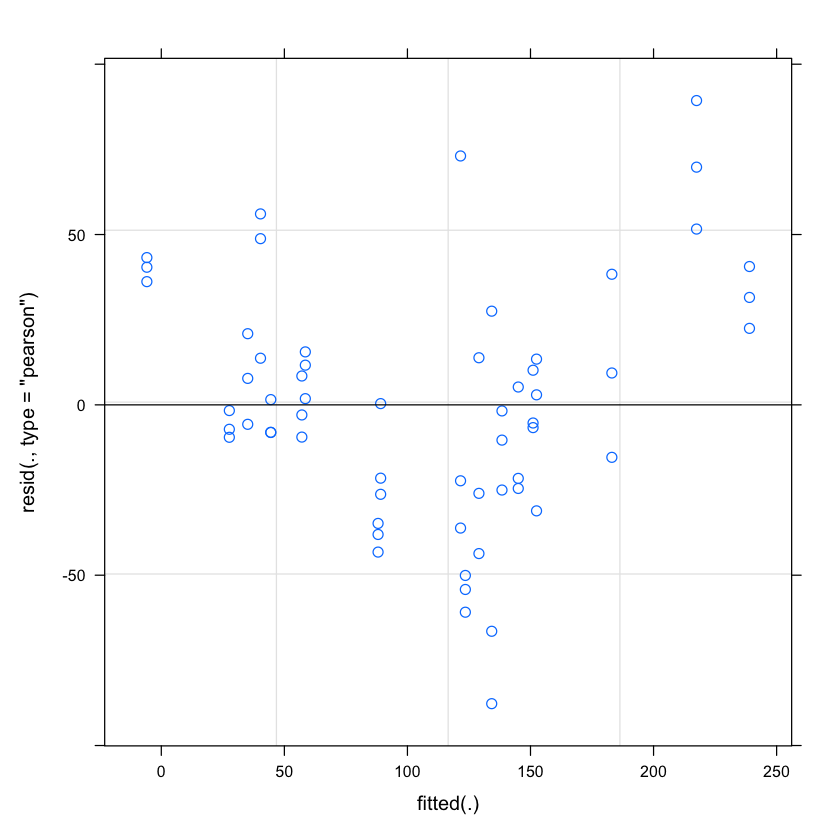

In [146]:
plot(lm.full)

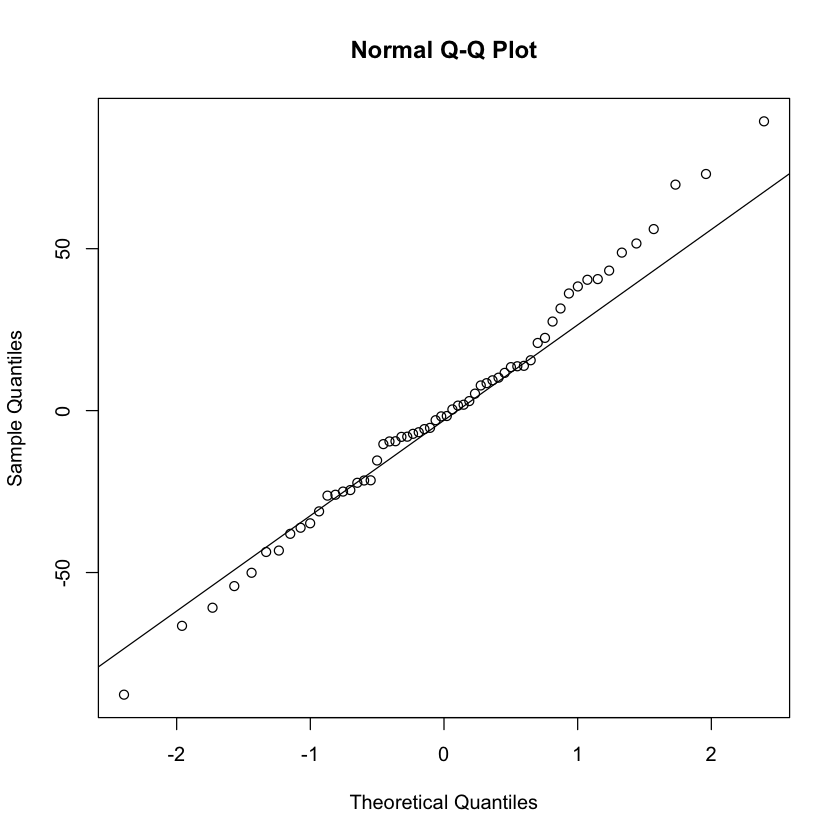

In [147]:
qqnorm(resid(lm.full))
qqline(resid(lm.full))

In [148]:
emmeans(lm.full, list(pairwise ~ Genotype | Treatment), adjust = "tukey")

$`emmeans of Genotype | Treatment`
Treatment = Vehicle:
 Genotype emmean   SE   df lower.CL upper.CL
 AA        175.5 29.8 1.84    36.38      315
 CC        160.6 29.8 1.84    21.50      300
 EIF2B2    104.8 35.2 3.27    -2.29      212

Treatment = Thapsi:
 Genotype emmean   SE   df lower.CL upper.CL
 AA         81.6 29.8 1.84   -57.55      221
 CC         66.7 29.8 1.84   -72.43      206
 EIF2B2     10.9 35.2 3.27   -96.23      118

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of Genotype | Treatment`
Treatment = Vehicle:
 2           estimate   SE df t.ratio p.value
 AA - CC         14.9 26.7  6 0.557   0.8470 
 AA - EIF2B2     70.7 32.7  6 2.159   0.1577 
 CC - EIF2B2     55.8 32.7  6 1.705   0.2785 

Treatment = Thapsi:
 2           estimate   SE df t.ratio p.value
 AA - CC         14.9 26.7  6 0.557   0.8470 
 AA - EIF2B2     70.7 32.7  6 2.159   0.1577 
 CC - EIF2B2     55.8 32.7  6 1.705   0.2785 

Degrees-of-freedom method: kenw

In [149]:
emmeans(lm.full, list(pairwise ~ Treatment | Genotype), adjust = "tukey")

$`emmeans of Treatment | Genotype`
Genotype = AA:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    175.5 29.8 1.84    36.38      315
 Thapsi      81.6 29.8 1.84   -57.55      221

Genotype = CC:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    160.6 29.8 1.84    21.50      300
 Thapsi      66.7 29.8 1.84   -72.43      206

Genotype = EIF2B2:
 Treatment emmean   SE   df lower.CL upper.CL
 Vehicle    104.8 35.2 3.27    -2.29      212
 Thapsi      10.9 35.2 3.27   -96.23      118

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of Treatment | Genotype`
Genotype = AA:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     93.9 9.87 49 9.520   <.0001 

Genotype = CC:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     93.9 9.87 49 9.520   <.0001 

Genotype = EIF2B2:
 2                estimate   SE df t.ratio p.value
 Vehicle - Thapsi     93.9 9.87 49 9.520   <.0001 

Degrees-of-freedom me